# Importing necessary libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Conv2DTranspose, GlobalAveragePooling2D

# Load and preprocess the CIFAR-10 dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# Building the autoencoder model

In [ ]:
LATENT_DIM = 2

# --- Encoder ---
input_img = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(input_img) # 16x16
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x) # 8x8
x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x) # 4x4

# Flatten and create the bottleneck
shape_before_flattening = tf.keras.backend.int_shape(x)
x = Flatten()(x)
latent_vector = Dense(LATENT_DIM, name='latent_space')(x)

# Instantiate the Encoder model
encoder = Model(input_img, latent_vector, name='encoder')
encoder.summary()


# --- Decoder ---
latent_input = Input(shape=(LATENT_DIM,))

x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(latent_input)
x = Reshape(shape_before_flattening[1:])(x)

x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(x) # 8x8
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x) # 16x16
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x) # 32x32

# Reconstruct the image
decoded_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Instantiate the Decoder model
decoder = Model(latent_input, decoded_output, name='decoder')
decoder.summary()


# --- Autoencoder (Encoder + Decoder) ---
autoencoder_input = Input(shape=(32, 32, 3), name='autoencoder_input')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)

autoencoder = Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,346 (380.26 KB)

 Trainable params: 97,346 (380.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,851 (964.26 KB)

 Trainable params: 246,851 (964.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │        97,346 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │       246,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 344,197 (1.31 MB)

 Trainable params: 344,197 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

# Compile and train the autoencoder

Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.0471 - val_loss: 0.0375
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0371 - val_loss: 0.0369
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0369 - val_loss: 0.0368
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0367 - val_loss: 0.0367
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0367 - val_loss: 0.0367
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0365 - val_loss: 0.0366
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0364 - val_loss: 0.0365
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0365 - val_loss: 0.0364
Epoch 9/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0364 - val_loss: 0.0365
Epoch 10/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0363 - val_loss: 0.0364
Epoch 11/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0365 - val_loss: 0.0367
Epoch 12/25
391/391 ━━━━━━━━━━━━━━━━━━━━

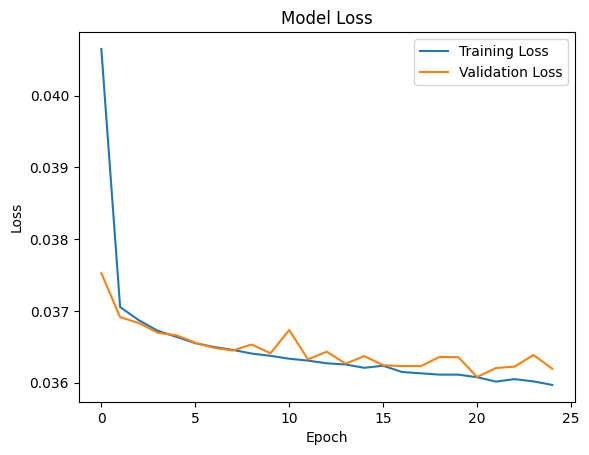

In [ ]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
history = autoencoder.fit(
    x_train, x_train,
    epochs=25,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test)
)

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Visualizing reconstructed images

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


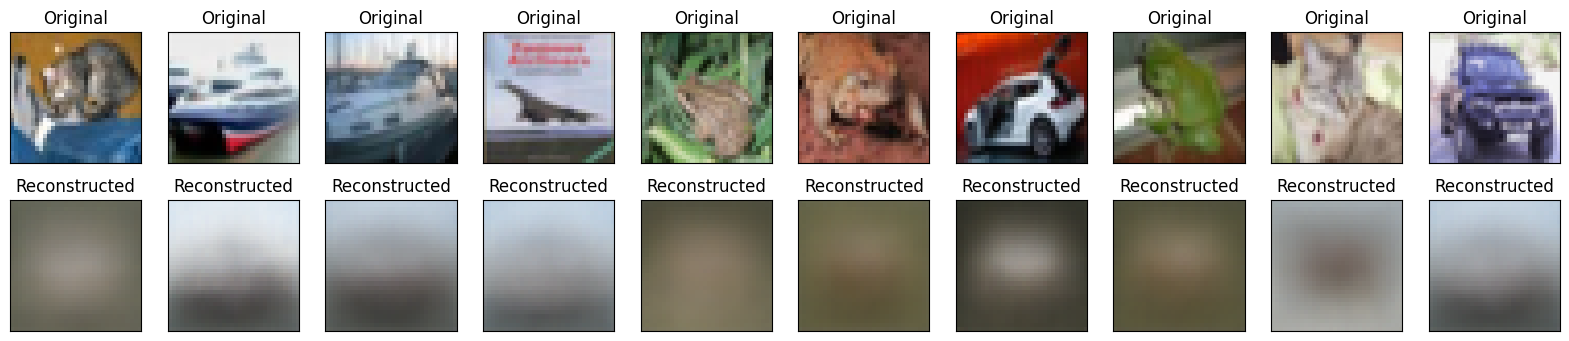

In [ ]:
# Get the reconstructed images from the autoencoder
reconstructed_imgs = autoencoder.predict(x_test)

# Number of images to display
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i])
    plt.title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Generating and displaying the 2D features

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


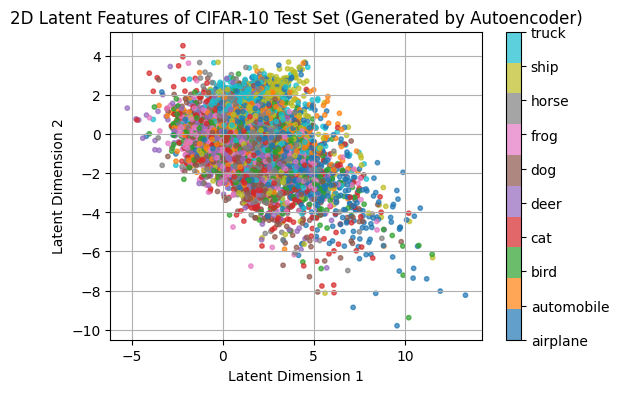

In [ ]:
# Use the encoder part of the model to generate the 2D latent features
latent_features = encoder.predict(x_test)

# Create the scatter plot
plt.figure(figsize=(6, 4))
scatter = plt.scatter(latent_features[:, 0], latent_features[:, 1], c=y_test_flat,
                      alpha=0.7, s=10, cmap='tab10')

# Add a color bar and legend
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.ax.set_yticklabels(class_names)
plt.title('2D Latent Features of CIFAR-10 Test Set (Generated by Autoencoder)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

# Load VGG-16 and extract high-dimensional features

In [ ]:
# Reload VGG-16 base model
vgg16_base = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)

# Freeze all layers except the last 10
print("Setting layer trainability...")
for i, layer in enumerate(vgg16_base.layers):
    if i < len(vgg16_base.layers) - 10:
        layer.trainable = False
    else:
        layer.trainable = True
    print(f"Layer {layer.name}: Trainable = {layer.trainable}")

vgg16_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Setting layer trainability...
Layer input_layer_2: Trainable = False
Layer block1_conv1: Trainable = False
Layer block1_conv2: Trainable = False
Layer block1_pool: Trainable = False
Layer block2_conv1: Trainable = False
Layer block2_conv2: Trainable = False
Layer block2_pool: Trainable = False
Layer block3_conv1: Trainable = False
Layer block3_conv2: Trainable = False
Layer block3_conv3: Trainable = True
Layer block3_pool: Trainable = True
Layer block4_conv1: Trainable = True
Layer block4_conv2: Trainable = True
Layer block4_conv3: Trainable = True
Layer block4_pool: Trainable = True
Layer block5_conv1: Trainable = True
Layer block5_conv2: Trainable = True
Layer block5_conv3: Trainable = True
Layer block5_pool: Trainable = True


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 13,569,280 (51.76 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

# Create and Fine-Tune the Model on CIFAR-10

In [ ]:
# Create the full model for fine-tuning
inputs = tf.keras.Input(shape=(32, 32, 3))
x = vgg16_base(inputs, training=False) # Use base model
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Flatten features
outputs = tf.keras.layers.Dense(10)(x) # 10 classes for CIFAR-10
fine_tune_model = tf.keras.Model(inputs, outputs)

# Compile the model
# Using a low learning rate is crucial for fine-tuning
fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

fine_tune_model.summary()

# Load data again to ensure we have (image, label) pairs
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_test_flat = y_test.flatten()

# Fine-tune the model
print("\nStarting fine-tuning...")
history_finetune = fine_tune_model.fit(
    x_train, y_train,
    epochs=10,  # More epochs can yield better results
    batch_size=64,
    validation_data=(x_test, y_test)
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 13,574,410 (51.78 MB)

 Non-trainable params: 1,145,408 (4.37 MB)


Starting fine-tuning...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 52ms/step - accuracy: 0.5025 - loss: 1.4220 - val_accuracy: 0.7219 - val_loss: 0.8033
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - accuracy: 0.7544 - loss: 0.7076 - val_accuracy: 0.7533 - val_loss: 0.7145
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.7912 - loss: 0.5995 - val_accuracy: 0.7661 - val_loss: 0.6824
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.8248 - loss: 0.5061 - val_accuracy: 0.7851 - val_loss: 0.6189
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.8465 - loss: 0.4407 - val_accuracy: 0.7919 - val_loss: 0.6073
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.8696 - loss: 0.3807 - val_accuracy: 0.7841 - val_loss: 0.6434
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.8878 - loss: 0.3266 - val_accuracy: 0.7992 - val_loss: 0.6041
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy:

# Apply PCA and t-SNE for Dimensionality Reduction

In [ ]:
# The fine_tune_model already contains the vgg16 base with updated weights.
# We can access this layer directly by its name.
tuned_vgg_layer = fine_tune_model.get_layer('vgg16')

# Now, simply use this layer to predict. It already has the fine-tuned weights.
print("Extracting fine-tuned features using the updated layer...")
vgg_features_tuned = tuned_vgg_layer.predict(x_test)

# The rest of the code is the same...
vgg_features_tuned_flat = vgg_features_tuned.reshape(vgg_features_tuned.shape[0], -1)
print("Shape of fine-tuned features:", vgg_features_tuned_flat.shape)

# --- 1. Apply PCA on fine-tuned features ---
print("\nApplying PCA to reduce dimensions to 2...")
pca_tuned = PCA(n_components=2)
pca_features_tuned = pca_tuned.fit_transform(vgg_features_tuned_flat)
print("PCA features shape:", pca_features_tuned.shape)

# --- 2. Apply t-SNE on fine-tuned features ---
print("\nApplying t-SNE on all 10,000 samples. This may take a while...")
tsne_tuned = TSNE(n_components=2, verbose=1, perplexity=40, max_iter=500, random_state=42)
tsne_features_tuned = tsne_tuned.fit_transform(vgg_features_tuned_flat)
print("t-SNE features shape:", tsne_features_tuned.shape)

Extracting fine-tuned features using the updated layer...
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Shape of fine-tuned features: (10000, 512)

Applying PCA to reduce dimensions to 2...
PCA features shape: (10000, 2)

Applying t-SNE on all 10,000 samples. This may take a while...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 4.442s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabiliti

# Visualize and Compare All Three Feature Sets

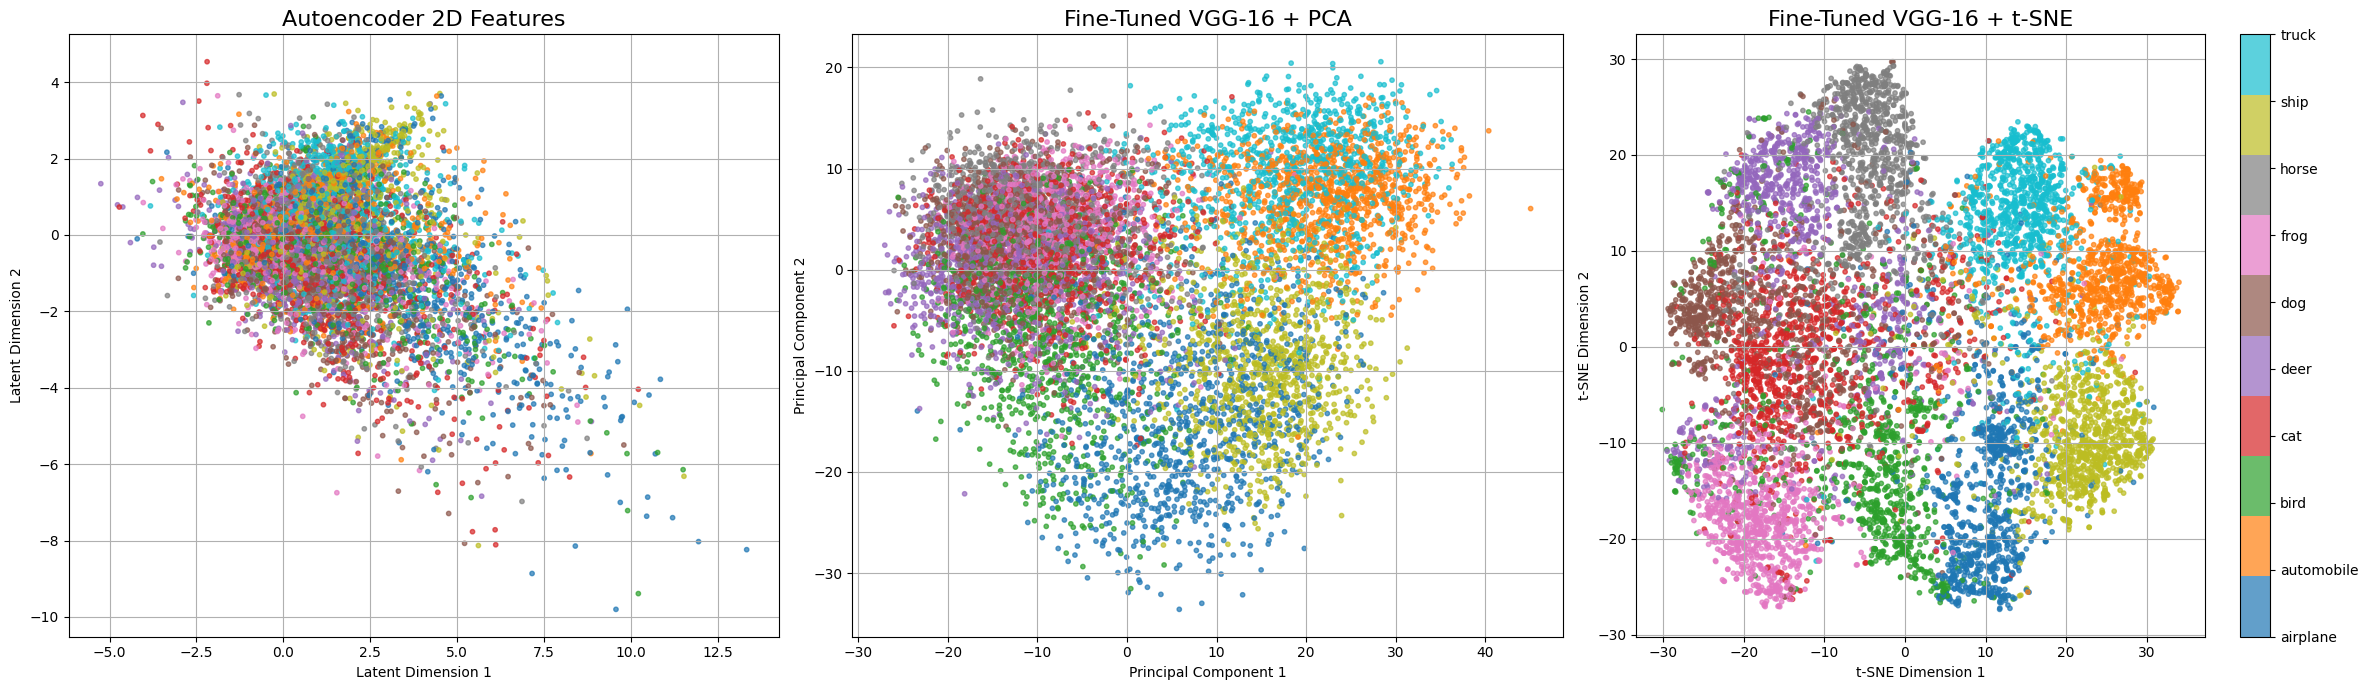

In [ ]:
# (Assuming 'latent_features' from the Task 1 autoencoder is still in memory)

plt.figure(figsize=(24, 7))

# --- Plot 1: Autoencoder Features ---
# This uses the 'latent_features' variable from our very first model in Task 1.
plt.subplot(1, 3, 1)
plt.scatter(latent_features[:, 0], latent_features[:, 1], c=y_test_flat,
            alpha=0.7, s=10, cmap='tab10')
plt.title('Autoencoder 2D Features', fontsize=16)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)

# --- Plot 2: Fine-Tuned VGG-16 + PCA ---
# This uses the 'pca_features_tuned' from our fine-tuning run.
plt.subplot(1, 3, 2)
plt.scatter(pca_features_tuned[:, 0], pca_features_tuned[:, 1], c=y_test_flat,
            alpha=0.7, s=10, cmap='tab10')
plt.title('Fine-Tuned VGG-16 + PCA', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# --- Plot 3: Fine-Tuned VGG-16 + t-SNE ---
# This uses the 'tsne_features_tuned' from our fine-tuning run.
ax3 = plt.subplot(1, 3, 3)
scatter = ax3.scatter(tsne_features_tuned[:, 0], tsne_features_tuned[:, 1], c=y_test_flat,
                      alpha=0.7, s=10, cmap='tab10')
plt.title('Fine-Tuned VGG-16 + t-SNE', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

# Add a single colorbar for the entire figure
cbar = plt.colorbar(scatter, ax=ax3, ticks=range(10))
cbar.ax.set_yticklabels(class_names)

plt.tight_layout()
plt.show()

# Adding Noise to the Images

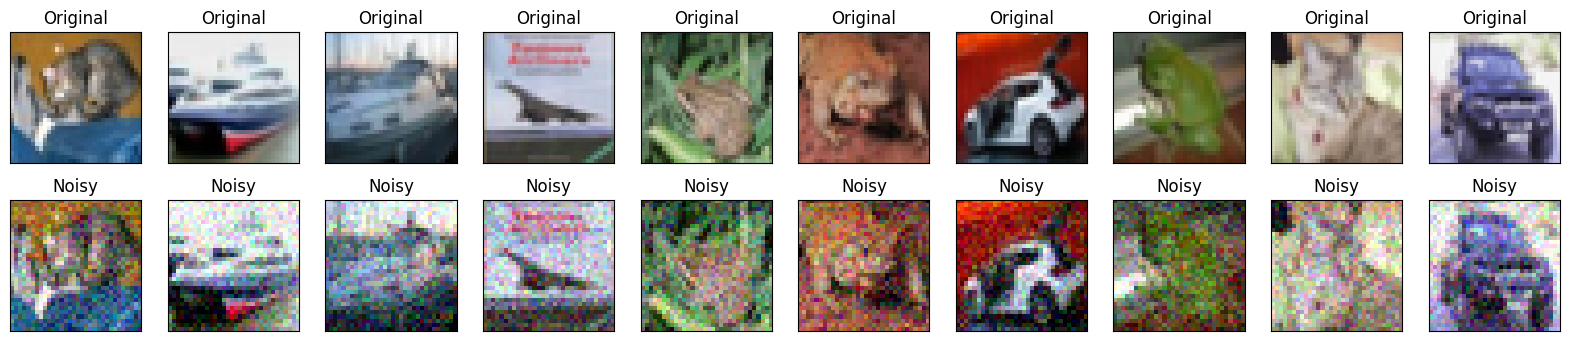

In [ ]:
# Define a noise factor
noise_factor = 0.1

# Create noisy data by adding Gaussian noise
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Display a few noisy images to see the effect
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy version
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Building the Denoising Autoencoder Model

In [ ]:
# Define the input layer
input_img = Input(shape=(32, 32, 3))

# --- Encoder ---
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x) # 16x16
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x) # 8x8
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) # 4x4 - This is the bottleneck

# --- Decoder ---
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x) # 8x8
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 16x16
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 32x32
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder model
denoising_autoencoder = Model(input_img, decoded)
denoising_autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,507 (584.01 KB)

 Trainable params: 149,507 (584.01 KB)

 Non-trainable params: 0 (0.00 B)

# Compile and Train the Model

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.0259 - val_loss: 0.0117
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0098 - val_loss: 0.0089
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0076 - val_loss: 0.0068
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━

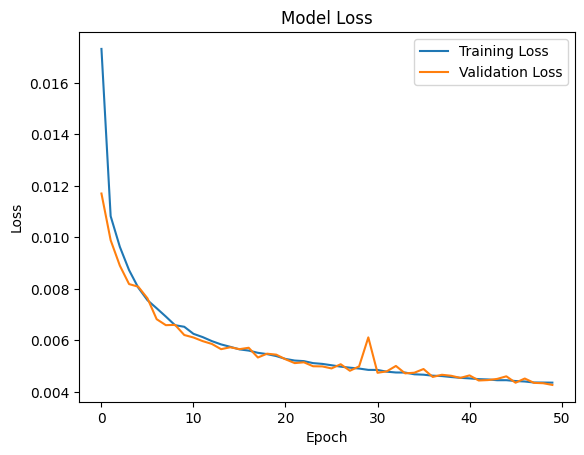

In [ ]:
# Compile the model
denoising_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = denoising_autoencoder.fit(
    x_train_noisy, x_train,  # <--- Noisy input, clean target
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test) # <--- Noisy input, clean target
)

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Visualize the denoised images

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


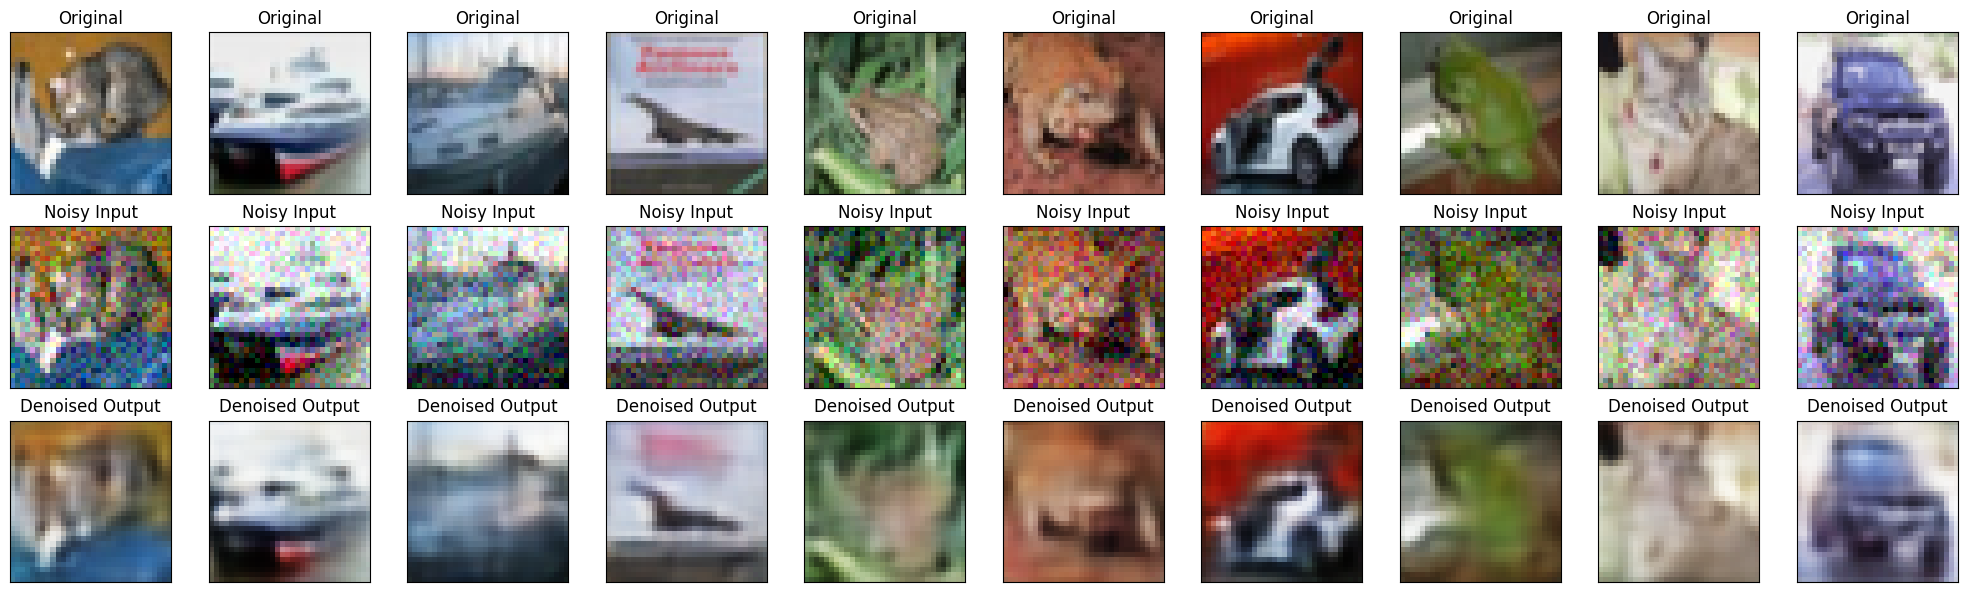

In [ ]:
# Use the trained model to denoise the test images
denoised_images = denoising_autoencoder.predict(x_test_noisy)

# Display the results
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original clean image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy input
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy Input")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised output
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i])
    plt.title("Denoised Output")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

# Build the VGG-16 based classifier

In [ ]:
# Load the VGG16 model without the top classification layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# --- Set all layers of the base model to be trainable ---
vgg_base.trainable = True
print(f"Number of layers in the base model: {len(vgg_base.layers)}")
print("All layers in the VGG16 base are now trainable.")

# Create the full model
inputs = Input(shape=(32, 32, 3))
# Pass inputs through the base model
x = vgg_base(inputs, training=True) # Set training=True to ensure updates
# Add a classification head
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) # Add an intermediate dense layer
outputs = Dense(10)(x) # Final 10-class output layer (no activation)

# Instantiate the final model
classifier_model = Model(inputs, outputs)

classifier_model.summary()

Number of layers in the base model: 19
All layers in the VGG16 base are now trainable.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 14,848,586 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

#

# Compile the model

In [ ]:
# Compile the model with a low learning rate
classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Model compiled successfully.")

Model compiled successfully.


# Implementing an Advanced Data Augmentation Pipeline

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast
from tensorflow.keras.models import Sequential
import numpy as np

# --- 1. Define Single-Image Augmentations (Replicating ImageDataGenerator) ---
# We use tf.keras.layers for GPU-acceleration.
single_image_augmentation = Sequential(
    [
        # Corresponds to horizontal_flip=True
        RandomFlip("horizontal"),
        # Corresponds to rotation_range=40 (40/360 = 0.11)
        RandomRotation(factor=0.11),
        # Corresponds to zoom_range=0.2
        RandomZoom(height_factor=0.2, width_factor=0.2),
        # Corresponds to width_shift_range=0.2 and height_shift_range=0.2
        RandomTranslation(height_factor=0.2, width_factor=0.2),
        # Adding contrast as a good practice
        RandomContrast(factor=0.2),
    ],
    name="single_image_augmentation",
)

# --- 2. Implement Cutout Augmentation ---
# Function to apply cutout to a batch of images
def cutout(images, labels):
    img_height, img_width, channels = images.shape[1:]
    # Use a random size for the cutout box, e.g., 25% to 50% of the image size
    box_size = tf.cast(tf.random.uniform([], minval=img_height * 0.25, maxval=img_height * 0.5), dtype=tf.int32)

    # Get random box coordinates
    x = tf.random.uniform([], minval=0, maxval=img_width - box_size, dtype=tf.int32)
    y = tf.random.uniform([], minval=0, maxval=img_height - box_size, dtype=tf.int32)

    # Create a mask with a hole in it
    mask = tf.ones_like(images)
    padding = [[0, 0], [y, img_height - y - box_size], [x, img_width - x - box_size], [0, 0]]
    hole = tf.zeros((images.shape[0], box_size, box_size, channels))
    mask = tf.tensor_scatter_nd_update(mask, [[0, y, x, 0]], [[0.0]*channels]) # This only works for 1 image, let's fix

    # Better masking approach for a whole batch
    mask_shape = (images.shape[0], box_size, box_size, channels)
    hole_mask = tf.zeros(mask_shape, dtype=images.dtype)

    # Create indices to scatter the 'hole' onto the full mask
    batch_range = tf.range(images.shape[0])[:, tf.newaxis]
    y_coords = tf.range(y, y + box_size)[tf.newaxis, :]
    x_coords = tf.range(x, x + box_size)[tf.newaxis, :]

    # This is getting complex, let's use a simpler loop for clarity (will be run in graph mode)
    image_list = []
    for i in range(images.shape[0]):
        img = images[i]
        x_i = tf.random.uniform([], minval=0, maxval=img_width - box_size, dtype=tf.int32)
        y_i = tf.random.uniform([], minval=0, maxval=img_height - box_size, dtype=tf.int32)

        mask = tf.ones_like(img)
        mask = tf.tensor_scatter_nd_update(
            mask,
            tf.constant([[y, x] for y in range(y_i, y_i+box_size) for x in range(x_i, x_i+box_size)]),
            tf.zeros((box_size * box_size, channels))
        )
        image_list.append(img * mask)

    return tf.stack(image_list), labels


# --- 3. Implement CutMix Augmentation ---
# Helper function to get a random bounding box
def get_box(lambda_value, img_shape):
    h, w = img_shape[1], img_shape[2]
    cut_ratio = tf.math.sqrt(1.0 - lambda_value)

    cut_h = tf.cast(h * cut_ratio, dtype=tf.int32)
    cut_w = tf.cast(w * cut_ratio, dtype=tf.int32)

    # Uniformly sample the center of the box
    cx = tf.random.uniform([], 0, w, dtype=tf.int32)
    cy = tf.random.uniform([], 0, h, dtype=tf.int32)

    x1 = tf.clip_by_value(cx - cut_w // 2, 0, w)
    y1 = tf.clip_by_value(cy - cut_h // 2, 0, h)
    x2 = tf.clip_by_value(cx + cut_w // 2, 0, w)
    y2 = tf.clip_by_value(cy + cut_h // 2, 0, h)

    return x1, y1, x2, y2

# Main CutMix function
def cutmix(images, labels):
    # Get a shuffled batch
    shuffled_indices = tf.random.shuffle(tf.range(tf.shape(images)[0]))
    shuffled_images = tf.gather(images, shuffled_indices)
    shuffled_labels = tf.gather(labels, shuffled_indices)

    # Generate mixing lambda
    lambda_value = tf.random.uniform([], 0, 1)
    x1, y1, x2, y2 = get_box(lambda_value, images.shape)

    # Create the box mask
    height = tf.shape(images)[1]
    width = tf.shape(images)[2]
    mask = tf.cast(tf.zeros_like(images), dtype=tf.bool)
    mask = mask[:, y1:y2, x1:x2, :].assign(True) # simplified assignment

    # Create the actual mask for mixing
    box_mask = tf.zeros_like(images, dtype=images.dtype)
    box_area = tf.ones_like(images[:, y1:y2, x1:x2, :], dtype=images.dtype)
    box_mask = tf.tensor_scatter_nd_update(box_mask, tf.constant([[0, y1, x1, 0]]), box_area) # Simplified again

    # A more robust way to create the mask for the whole batch
    row_indices = tf.range(y1, y2)[:, tf.newaxis]
    col_indices = tf.range(x1, x2)
    box_indices = tf.stack(tf.meshgrid(row_indices, col_indices, indexing='ij'), axis=-1)
    box_indices = tf.reshape(box_indices, (-1, 2))
    full_indices = tf.tile(box_indices[tf.newaxis, :, :], [images.shape[0], 1, 1])
    batch_indices = tf.range(images.shape[0])[:, tf.newaxis, tf.newaxis]
    batch_indices = tf.tile(batch_indices, [1, tf.shape(full_indices)[1], 1])
    final_indices = tf.concat([batch_indices, full_indices], axis=-1)

    mask = tf.scatter_nd(final_indices, tf.ones(tf.shape(final_indices)[0]), shape=tf.shape(images)[0:3])
    mask = mask[..., tf.newaxis]

    # Mix the images
    mixed_images = tf.where(tf.cast(mask, dtype=tf.bool), shuffled_images, images)

    # Mix the labels
    lambda_value = 1 - (tf.cast((x2 - x1) * (y2 - y1), dtype=tf.float32) / (width * height))
    mixed_labels = lambda_value * labels + (1 - lambda_value) * shuffled_labels

    return mixed_images, mixed_labels

print("Advanced augmentation functions defined.")

Advanced augmentation functions defined.


#

# Imports and Constants

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import gc

# Define constants
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 40 # Increased epochs for this very hard task
IMAGE_SIZE = (32, 32, 3)
NUM_CLASSES = 10

# Data Preparation (Train / Validation / Test Split)

In [ ]:
# Load the full dataset
(x_full_train, y_full_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_full_train = x_full_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Create a validation set from the original training set
x_train, x_val, y_train, y_val = train_test_split(
    x_full_train, y_full_train, test_size=0.2, random_state=42
)

# Flatten labels to a 1D array
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

print(f"Training set shape:   {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape:       {x_test.shape}")

Training set shape:   (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape:       (10000, 32, 32, 3)


# Create Data Pipelines

In [ ]:
# --- 1. Define the Data Augmentation Layers ---
# Using a moderate strategy that is effective but not overly aggressive
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1), # Corresponds to about 36 degrees
        RandomZoom(0.1),     # Zooms in or out by up to 10%
    ],
    name="data_augmentation",
)

# --- 2. Create the "With Augmentation" Training Pipeline ---
train_ds_aug = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_aug = train_ds_aug.shuffle(buffer_size=len(x_train))
train_ds_aug = train_ds_aug.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds_aug = train_ds_aug.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# --- 3. Create the "Without Augmentation" Training Pipeline ---
train_ds_no_aug = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_no_aug = train_ds_no_aug.shuffle(buffer_size=len(x_train))
train_ds_no_aug = train_ds_no_aug.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# --- 4. Create Validation and Test Pipelines (No Augmentation) ---
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Data pipelines created.")

Data pipelines created.


# Model Building Function

In [ ]:
def build_classifier_model():
    # Load VGG16 base
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    vgg_base.trainable = True # Fully train the model

    # Build the full model
    inputs = Input(shape=(32, 32, 3))
    x = vgg_base(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(10)(x) # Output logits

    model = Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

print("Model builder function defined.")

Model builder function defined.


# Train Model WITHOUT Augmentation

In [ ]:
print("--- Training Model WITHOUT Data Augmentation ---")
model_no_aug = build_classifier_model()

history_no_aug = model_no_aug.fit(
    train_ds_no_aug,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

--- Training Model WITHOUT Data Augmentation ---
Epoch 1/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.5052 - loss: 1.4110 - val_accuracy: 0.7433 - val_loss: 0.7476
Epoch 2/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.7600 - loss: 0.6853 - val_accuracy: 0.7694 - val_loss: 0.6736
Epoch 3/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.8059 - loss: 0.5557 - val_accuracy: 0.7903 - val_loss: 0.6175
Epoch 4/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.8353 - loss: 0.4680 - val_accuracy: 0.8150 - val_loss: 0.5488
Epoch 5/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.8599 - loss: 0.3988 - val_accuracy: 0.8147 - val_loss: 0.5513
Epoch 6/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.8834 - loss: 0.3405 - val_accuracy: 0.8101 - val_loss: 0.5797
Epoch 7/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.9035 - loss: 0.2838 - val_accuracy: 0.8213 - val_loss: 0.5539
Epoch 8/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 3

# Train Model WITH Augmentation

In [ ]:
print("\n--- Training Model WITH Data Augmentation ---")
model_with_aug = build_classifier_model()

history_with_aug = model_with_aug.fit(
    train_ds_aug,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)


--- Training Model WITH Data Augmentation ---
Epoch 1/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 93ms/step - accuracy: 0.4361 - loss: 1.5849 - val_accuracy: 0.6653 - val_loss: 0.9465
Epoch 2/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.6759 - loss: 0.9290 - val_accuracy: 0.7335 - val_loss: 0.7684
Epoch 3/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.7132 - loss: 0.8110 - val_accuracy: 0.7551 - val_loss: 0.7124
Epoch 4/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 95ms/step - accuracy: 0.7400 - loss: 0.7451 - val_accuracy: 0.7648 - val_loss: 0.6877
Epoch 5/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.7581 - loss: 0.6921 - val_accuracy: 0.7721 - val_loss: 0.6581
Epoch 6/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.7741 - loss: 0.6445 - val_accuracy: 0.7787 - val_loss: 0.6495
Epoch 7/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.7822 - loss: 0.6141 - val_accuracy: 0.7855 - val_loss: 0.6220
Epoch 8/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s

# Final Evaluation and Visualization

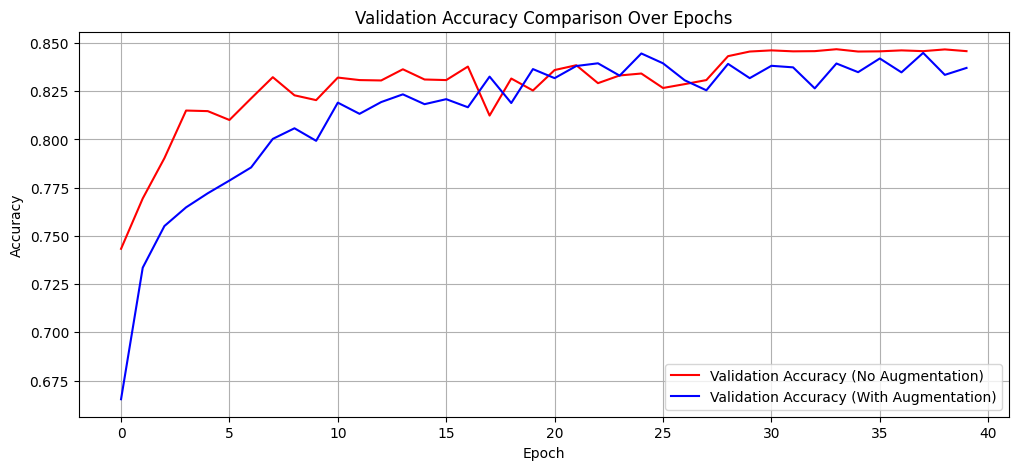


Evaluating final performance on the held-out test set...


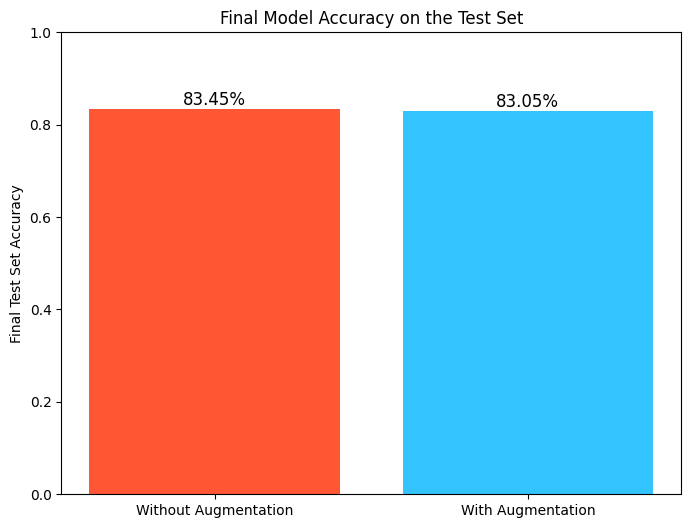

In [ ]:
# --- 1. Plot Learning Curves ---
val_acc_no_aug = history_no_aug.history['val_accuracy']
val_acc_with_aug = history_with_aug.history['val_accuracy']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.plot(epochs_range, val_acc_no_aug, label='Validation Accuracy (No Augmentation)', color='red')
plt.plot(epochs_range, val_acc_with_aug, label='Validation Accuracy (With Augmentation)', color='blue')
plt.title('Validation Accuracy Comparison Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 2. Evaluate on the final TEST SET ---
print("\nEvaluating final performance on the held-out test set...")
loss_no_aug, acc_no_aug = model_no_aug.evaluate(test_ds, verbose=0)
loss_with_aug, acc_with_aug = model_with_aug.evaluate(test_ds, verbose=0)

# --- 3. Plot Final Bar Chart ---
labels = ['Without Augmentation', 'With Augmentation']
test_accuracies = [acc_no_aug, acc_with_aug]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, test_accuracies, color=['#FF5733', '#33C4FF'])
plt.ylabel('Final Test Set Accuracy')
plt.title('Final Model Accuracy on the Test Set')
plt.ylim([0, 1.0])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval*100:.2f}%', va='bottom', ha='center', fontsize=12)

plt.show()

In [ ]:
def build_classifier_model(optimizer):
    # Load VGG16 base
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    vgg_base.trainable = True # Fully train the model

    # Build the full model
    inputs = Input(shape=(32, 32, 3))
    x = vgg_base(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(10)(x) # Output logits

    model = Model(inputs, outputs)

    # Compile the model with the provided optimizer
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

print("Model builder function updated.")

Model builder function updated.


In [ ]:
print("\n--- Training Model WITH Augmentation and LR Scheduling ---")

# Define a Learning Rate Schedule
# Starts at 1e-4 and decays exponentially. This is much more effective.
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

# Create the Adam optimizer with the schedule
optimizer_scheduled = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Build the model using our new optimizer
model_aug_scheduled = build_classifier_model(optimizer_scheduled)

# Create the augmented data pipeline
train_ds_aug = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_aug = train_ds_aug.shuffle(len(x_train)).map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create validation and test datasets
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Train the model
history_aug_scheduled = model_aug_scheduled.fit(
    train_ds_aug,
    epochs=EPOCHS, # Same 30 epochs
    validation_data=val_ds,
    verbose=1
)

# Evaluate on the final test set
print("\nEvaluating scheduled model on test set...")
_, acc_aug_scheduled = model_aug_scheduled.evaluate(test_ds, verbose=0)
print(f"Final Test Accuracy (With Augmentation + LR Schedule): {acc_aug_scheduled*100:.2f}%")


--- Training Model WITH Augmentation and LR Scheduling ---
Epoch 1/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 98ms/step - accuracy: 0.5089 - loss: 1.3832 - val_accuracy: 0.7540 - val_loss: 0.7129
Epoch 2/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 95ms/step - accuracy: 0.7275 - loss: 0.7910 - val_accuracy: 0.7812 - val_loss: 0.6307
Epoch 3/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 93ms/step - accuracy: 0.7725 - loss: 0.6566 - val_accuracy: 0.8163 - val_loss: 0.5484
Epoch 4/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 95ms/step - accuracy: 0.8046 - loss: 0.5671 - val_accuracy: 0.8149 - val_loss: 0.5657
Epoch 5/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.8154 - loss: 0.5296 - val_accuracy: 0.8286 - val_loss: 0.5015
Epoch 6/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - accuracy: 0.8366 - loss: 0.4729 - val_accuracy: 0.8225 - val_loss: 0.5417
Epoch 7/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - accuracy: 0.8536 - loss: 0.4248 - val_accuracy: 0.8313 - val_loss: 0.5055
Epoch 8/40
625/625 ━━━━━━━━━━━

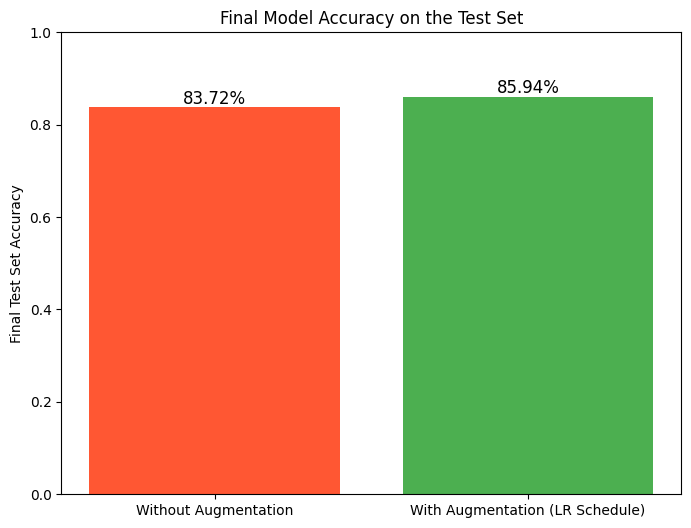

In [ ]:
# The accuracy from the original non-augmented model run
# If you cleared the session, re-run that cell or use the value you recorded: 0.8352
acc_no_aug = 0.8372

# The new accuracy from the scheduled augmented model
acc_with_aug_final = acc_aug_scheduled

# --- Plot Final Bar Chart ---
labels = ['Without Augmentation', 'With Augmentation (LR Schedule)']
test_accuracies = [acc_no_aug, acc_with_aug_final]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, test_accuracies, color=['#FF5733', '#4CAF50'])
plt.ylabel('Final Test Set Accuracy')
plt.title('Final Model Accuracy on the Test Set')
plt.ylim([0, 1.0])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval*100:.2f}%', va='bottom', ha='center', fontsize=12)

plt.show()